In [187]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%aimport util
from util import *
%autoreload 1

from PIL import Image, ImageFilter
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
delighted_dirs, lighted_dirs = scan_lighted_delighted('data/')
delighted_data, lighted_data = load_dataset(delighted_dirs, lighted_dirs)
test_meshes = ['Mesh_000003', 'Mesh_000006']
train_lighted_data = [(label, arr) for label, arr in lighted_data if label not in test_meshes]
test_lighted_data = [(label, arr) for label, arr in lighted_data if label in test_meshes]
np.random.seed(0)
np.random.shuffle(train_lighted_data)

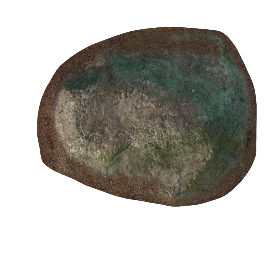

In [194]:
delighted, ao, bn, alpha = delighted_data[label]
show(img)

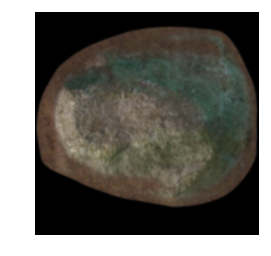

In [193]:
blurred_image = Image.fromarray(img).filter(ImageFilter.GaussianBlur(radius=10))
show(blurred_image)

In [140]:
FULL_HEIGHT = 1024
TRAIN_HEIGHT = 32
TEST_HEIGHT = FULL_HEIGHT

train_input_dimensions = (TRAIN_HEIGHT, TRAIN_HEIGHT, 3)
test_input_dimensions = (TEST_HEIGHT, TEST_HEIGHT, 3)

In [141]:
def fc(x, output_depth, name, activation=tf.nn.relu):
    input_depth = int(x.get_shape()[-1])
    with tf.variable_scope(name):
        W = tf.get_variable('W', shape=[input_depth, output_depth], initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('b', [output_depth], initializer=tf.zeros_initializer())
        return activation(tf.matmul(x, W) + b)
    
def conv2d(x, output_depth, name, filter_size=3, stride=1, padding='SAME'):
    input_depth = int(x.get_shape()[-1])

    with tf.variable_scope(name):
        W = tf.get_variable('W',
                            shape=[filter_size, filter_size, input_depth, output_depth],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('b', shape=[output_depth], initializer=tf.zeros_initializer())
        conv_output = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding) + b
        return tf.nn.relu(conv_output)

def deconv2d(x, output_depth, name, filter_size=3, stride=1, padding='SAME'):
    _, old_height, old_width, input_depth = x.get_shape().as_list()
    x = conv2d(x, output_depth, name, filter_size=filter_size, stride=stride, padding=padding)
    with tf.variable_scope(name):
        # bilinear interpolation upsampling
        scale = 2
        new_height = old_height * scale
        new_width = old_width * scale
        return tf.image.resize_images(x, [new_height, new_width], method=tf.image.ResizeMethod.BILINEAR)

In [158]:
class GeneratorNetwork(object):
    def __init__(self, session, train_input_dimensions, test_input_dimensions,
                 hyperparameters=None,
                 input_residual=False,
                 alpha_mask_loss=False,
                 concat_ao=False,
                 concat_bn=False):
        self.sess = session
        self.train_input_dimensions = list(train_input_dimensions)
        self.test_input_dimensions = list(test_input_dimensions)
        if not hyperparameters:
            hyperparameters = {
                'learning_rate' : 1e-3,
                'gdl_alpha' : 1,
                'lambda_l2' : 1,
                'lambda_gdl' : 1,
                'lambda_adv' : 1
            }
        self.hyperparams = hyperparameters
        self.train_variables = []
        self.has_defined_layers = False
        self.input_residual = input_residual
        self.alpha_mask_loss = alpha_mask_loss
        self.concat_ao = concat_ao
        self.concat_bn = concat_bn
    
    def init_network(self, discriminator):
        train_width, train_height, train_depth = self.train_input_dimensions
        test_width, test_height, test_depth = self.test_input_dimensions
        self.train_input = tf.placeholder(tf.float32, shape=[None, train_width, train_height, train_depth])
        self.train_ao_input = tf.placeholder(tf.float32, shape=[None, train_width, train_height, 1])
        self.train_bn_input = tf.placeholder(tf.float32, shape=[None, train_width, train_height, 3])
        self.alpha_mask = tf.placeholder(tf.float32, shape=[None, train_width, train_height, 1])
        self.test_input = tf.placeholder(tf.float32, shape=[None, test_width, test_height, test_depth])
        self.test_ao_input = tf.placeholder(tf.float32, shape=[None, test_width, test_height, 1])
        self.test_bn_input = tf.placeholder(tf.float32, shape=[None, test_width, test_height, 3])
        self.expected_output = tf.placeholder(tf.float32, shape=[None, train_width, train_height, train_depth])
        train_input = self.train_input
        test_input = self.test_input
        if self.concat_ao:
            train_input = tf.concat((train_input, self.train_ao_input), axis=3)
            test_input = tf.concat((test_input, self.test_ao_input), axis=3)
        if self.concat_bn:
            train_input = tf.concat((train_input, self.train_bn_input), axis=3)
            test_input = tf.concat((test_input, self.test_bn_input), axis=3)
            
        train_output = self.get_output_tensor(train_input)
        self.test_output = self.get_output_tensor(test_input)
        
        sq_diff = tf.squared_difference(train_output, self.expected_output)
        if self.alpha_mask_loss:
            sq_diff *= self.alpha_mask
        l2_loss = tf.reduce_mean(sq_diff)
        gdl_loss = self.gradient_difference_loss(train_output, self.expected_output, self.alpha_mask)
        adv_loss = -tf.reduce_mean(tf.log(discriminator.get_output_tensor(train_output)))
        self.loss = self.hyperparams['lambda_l2'] * l2_loss \
                  + self.hyperparams['lambda_gdl'] * gdl_loss \
                  + self.hyperparams['lambda_adv'] * adv_loss
        self.opt = tf.train.AdamOptimizer(learning_rate=self.hyperparams['learning_rate']).minimize(self.loss, var_list=self.train_variables)
        with tf.name_scope('generator'):
            l2_loss_summ = tf.summary.scalar('l2_loss', l2_loss)
            gdl_loss_summ = tf.summary.scalar('gradient_difference_loss', gdl_loss)
            adversarial_loss_summ = tf.summary.scalar('adversarial_loss', adv_loss)
            loss_summ = tf.summary.scalar('loss', self.loss)
            self.summaries = tf.summary.merge([l2_loss_summ, gdl_loss_summ, adversarial_loss_summ, loss_summ])
    
    def gradient_difference_loss(self, expected, predicted, alpha_mask):
        pos = tf.constant(np.identity(3), dtype=tf.float32)
        filter_x = tf.expand_dims(tf.stack([-pos, pos]), 0)  # [-1, 1]
        filter_y = tf.stack([tf.expand_dims(pos, 0), tf.expand_dims(-pos, 0)])  # [[1], [-1]]

        predicted_dx = tf.abs(tf.nn.conv2d(predicted, filter_x, [1, 1, 1, 1], padding='SAME'))
        predicted_dy = tf.abs(tf.nn.conv2d(predicted, filter_y, [1, 1, 1, 1], padding='SAME'))
        expected_dx = tf.abs(tf.nn.conv2d(expected, filter_x, [1, 1, 1, 1], padding='SAME'))
        expected_dy = tf.abs(tf.nn.conv2d(expected, filter_y, [1, 1, 1, 1], padding='SAME'))

        grad_diff_x = tf.abs(expected_dx - predicted_dx)
        grad_diff_y = tf.abs(expected_dy - predicted_dy)
        diff = grad_diff_x ** self.hyperparams['gdl_alpha'] + grad_diff_y ** self.hyperparams['gdl_alpha']
        if self.alpha_mask_loss:
            diff *= alpha_mask
        return tf.reduce_mean(diff)
    
    def get_output_tensor(self, input):
        with tf.variable_scope('generator', reuse=self.has_defined_layers):
            encoder0 = conv2d(input, 8, 'encoder_0')
            encoder1 = conv2d(encoder0, 16, 'encoder_1', stride=2)
            encoder2 = conv2d(encoder1, 32, 'encoder_2', stride=2)
            mid0 = conv2d(encoder2, 32, 'mid_0')
            decoder0 = deconv2d(tf.concat([mid0, encoder2], axis=3), 16, 'decoder_0')
            decoder1 = deconv2d(tf.concat([decoder0, encoder1], axis=3), 8, 'decoder_1')
            if self.input_residual:
                W = tf.get_variable('input_scale', shape=1, initializer=tf.constant_initializer(1))
                output = input[:, :, :, :3] * W + conv2d(tf.concat([decoder1, encoder0], axis=3), 3, 'decoder_2')
            else:
                output = conv2d(decoder1, 3, 'decoder_2')
        if not self.has_defined_layers:
            self.train_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
            self.has_defined_layers = True
        return output
    
    def fit_batch(self, expected_outputs, inputs, ao_inputs, bn_inputs, alphas):
        _, loss, summaries = self.sess.run((self.opt, self.loss, self.summaries),
                                           feed_dict={
                                               self.train_input : inputs,
                                               self.expected_output : expected_outputs,
                                               self.train_ao_input : ao_inputs,
                                               self.train_bn_input : bn_inputs,
                                               self.alpha_mask : alphas,
                                           })
        return loss, summaries
                
    def predict(self, inputs, ao_inputs, bn_inputs):
        return self.sess.run(self.test_output, feed_dict={ self.test_input : inputs, self.test_ao_input : ao_inputs, self.test_bn_input : bn_inputs })
    
class DiscriminatorNetwork(object):
    def __init__(self, session, train_input_dimensions, learning_rate=1e-3):
        self.sess = session
        self.train_input_dimensions = list(train_input_dimensions)
        self.learning_rate = learning_rate
        self.train_variables = []
        self.has_defined_layers = False
    
    def init_network(self, generator):
        train_width, train_height, train_depth = self.train_input_dimensions
        self.lighted_input = tf.placeholder(tf.float32, shape=[None, train_width, train_height, train_depth])
        self.ao_input = tf.placeholder(tf.float32, shape=[None, train_width, train_height, 1])
        self.bn_input = tf.placeholder(tf.float32, shape=[None, train_width, train_height, 3])
        lighted_input = self.lighted_input
        if generator.concat_ao:
            lighted_input = tf.concat((lighted_input, self.ao_input), axis=3)
        if generator.concat_bn:
            lighted_input = tf.concat((lighted_input, self.bn_input), axis=3)
        
        self.delighted_input = tf.placeholder(tf.float32, shape=[None, train_width, train_height, train_depth])
        real_input = self.delighted_input
        fake_input = generator.get_output_tensor(lighted_input)
        
        predicted_real = self.get_output_tensor(real_input)
        predicted_fake = self.get_output_tensor(fake_input)
        
        real_loss = -tf.reduce_mean(tf.log(predicted_real))
        fake_loss = -tf.reduce_mean(tf.log(1 - predicted_fake))
        
        self.loss = real_loss + fake_loss
        self.opt = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.train_variables)
        with tf.name_scope('discriminator'):
            real_loss_summ = tf.summary.scalar('real_loss', real_loss)
            fake_loss_summ = tf.summary.scalar('fake_loss', fake_loss)
            loss_summ = tf.summary.scalar('loss', self.loss)
            self.summaries = tf.summary.merge([real_loss_summ, fake_loss_summ, loss_summ])
            
    def get_output_tensor(self, input):
        '''
        Given an input tensor / placeholder, perform convs then FCs to get the probability that input is real
        '''
        with tf.variable_scope('discriminator', reuse=self.has_defined_layers):
            conv0 = conv2d(input, 4, 'conv_0', stride=2)
            conv1 = conv2d(conv0, 8, 'conv_1', stride=2)
            conv2 = conv2d(conv1, 16, 'conv_2', stride=2)
            fc_input = tf.contrib.layers.flatten(conv2)
            fc_0 = fc(fc_input, 256, 'fc_0')
            fc_1 = fc(fc_0, 128, 'fc_1')
            output = fc(fc_1, 1, 'fc_2', activation=tf.nn.sigmoid)
        if not self.has_defined_layers:
            self.train_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
            self.has_defined_layers = True
        return output
        
    def fit_batch(self, delighted_inputs, lighted_inputs, ao_inputs, bn_inputs):
        _, loss, summaries = self.sess.run((self.opt, self.loss, self.summaries), feed_dict={ self.lighted_input : lighted_inputs, self.delighted_input : delighted_inputs, self.ao_input : ao_inputs, self.bn_input : bn_inputs})
        return loss, summaries

In [172]:
def get_train_batch(delighted_data, lighted_data, batch_size, i):
    inputs = []
    expected_outputs = []
    aos = []
    bns = []
    alphas = []
    for i, (mesh, input) in enumerate(lighted_data[i * batch_size : (i + 1) * batch_size]):
        while True:
            start_x, start_y = np.random.randint(0, FULL_HEIGHT - TRAIN_HEIGHT + 1, size=(2,))
            sample = input[start_x : start_x + TRAIN_HEIGHT, start_y : start_y + TRAIN_HEIGHT]
            if np.sum(sample > 0) > 0.1 * TRAIN_HEIGHT ** 2:
                rotate_rand = np.random.randint(4)
                flip_rand = np.random.randint(0, 1, size=1)[0]
                flip = lambda x: x
                if flip_rand:
                    flip = lambda x: np.flip(x, axis=0)
                rotate = lambda x: np.rot90(x, rotate_rand)
                sample = rotate(sample)
                delighted, ao, bn, alpha = [
                    flip(rotate(im[start_x : start_x + TRAIN_HEIGHT, start_y : start_y + TRAIN_HEIGHT]))
                    for im in delighted_data[mesh]
                ]
                inputs.append(sample)
                expected_outputs.append(delighted)
                aos.append(ao)
                bns.append(bn)
                alphas.append(alpha)
                break
    return np.asarray(expected_outputs), np.asarray(inputs), np.asarray(aos), np.asarray(bns), np.asarray(alphas)

def get_test_batch(delighted_data, lighted_data, batch_size, i):
    meshes, inputs = zip(*lighted_data[i * batch_size : (i + 1) * batch_size])
    inputs = np.asarray(inputs)
    expected_outputs, aos, bns, alphas = [np.asarray(arr) for arr in zip(*(delighted_data[mesh] for mesh in meshes))]
    return expected_outputs, inputs, aos, bns, alphas

def restore(sess, checkpoint_file):
    saver = tf.train.Saver()
    saver.restore(sess, checkpoint_file)
    
def save(sess, checkpoint_file):
    saver = tf.train.Saver()
    saver.save(sess, checkpoint_file)

In [259]:
tf.reset_default_graph()
sess = tf.Session()
gen_hyperparams = {
    'learning_rate' : 1e-4,
    'gdl_alpha' : 1,
    'lambda_l2' : 0.3,
    'lambda_gdl' : 5,
    'lambda_adv' : 5
}
generator = GeneratorNetwork(sess, train_input_dimensions, test_input_dimensions, gen_hyperparams,
                             input_residual=True,
                             alpha_mask_loss=True,
                             concat_ao=True,
                             concat_bn=True)
discriminator = DiscriminatorNetwork(sess, train_input_dimensions, learning_rate=1e-4)
generator.init_network(discriminator)
discriminator.init_network(generator)

sess.run(tf.global_variables_initializer())

In [ ]:
epochs = 600
n_samples = len(train_lighted_data)
batch_size = 50
display_step = 1
iters_per_epoch = n_samples // batch_size
summary_interval = iters_per_epoch
start_epoch = 0

summary_writer = tf.summary.FileWriter('summaries/test', graph=sess.graph)
mean_gen_losses = []
mean_disc_losses = []
for epoch in range(start_epoch, start_epoch + epochs):
    total_gen_loss = 0
    total_disc_loss = 0
    for i in range(iters_per_epoch):
        expected_outputs, inputs, aos, bns, alphas = get_train_batch(delighted_data, train_lighted_data, batch_size, i)
        gen_loss, gen_summaries = generator.fit_batch(expected_outputs, inputs, aos, bns, alphas)
        disc_loss, disc_summaries = discriminator.fit_batch(expected_outputs, inputs, aos, bns)
        if (i + 1) % summary_interval == 0:
            step = epoch * n_samples + (i + 1) * batch_size
            summary_writer.add_summary(gen_summaries, step)
            summary_writer.add_summary(disc_summaries, step)
        total_gen_loss += gen_loss
        total_disc_loss += disc_loss
    mean_gen_loss = total_gen_loss / iters_per_epoch
    mean_disc_loss = total_disc_loss / iters_per_epoch
    mean_gen_losses.append(mean_gen_loss)
    mean_disc_losses.append(mean_disc_loss)
    if (epoch + 1) % display_step == 0:
        print('epoch %s: gen_loss=%.4f, disc_loss=%.4f' % (epoch + 1, mean_gen_loss, mean_disc_loss))

In [262]:
save(sess, 'models/input_to_output_alpha_mask_ao_bn-600')

lighted


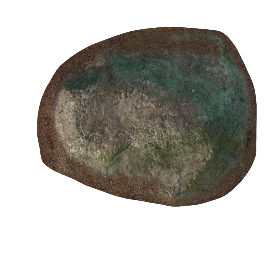

delighted


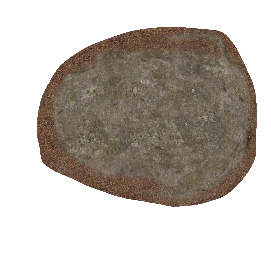

predicted


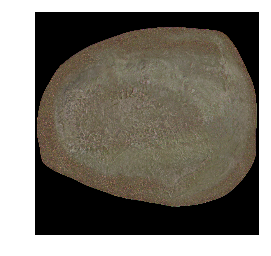

In [261]:
label, img = test_lighted_data[40]
def show(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()
print('lighted')
show(img)
print('delighted')
delighted, ao, bn, alpha = delighted_data[label]
show(delighted)
print('predicted')
predicted = generator.predict(np.array([img]), np.array([ao]), np.array([bn]))
show(float_to_uint8(predicted * alpha)[0])

In [263]:
import os
out_dir = 'results/input_to_output_alpha_mask_ao_bn/'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
for i in range(50):
    label, img = lighted_data[i]
    mesh_dir = out_dir + '%s/' % (label)
    if not os.path.exists(mesh_dir):
        os.mkdir(mesh_dir)
    img_dir = mesh_dir + '%s/' % (i)
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    plt.imshow(img)
    plt.axis('off')
    plt.savefig(img_dir + 'lighted.png')
    plt.clf()
    
    delighted, ao, bn, alpha = delighted_data[label]
    predicted = generator.predict(np.array([img]), np.array([ao]), np.array([bn]))

    plt.imshow(delighted)
    plt.axis('off')
    plt.savefig(mesh_dir + 'delighted_ground_truth.png')
    plt.clf()
    
    plt.imshow(float_to_uint8(predicted * alpha)[0])
    plt.axis('off')
    plt.savefig(img_dir + 'delighted_output.png')
    plt.clf()